<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Diffusion de particules
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Approche microscopique de la diffusion | Marche au hasard
             </div>
        </div>
    </div>
</div>

# Mise en œuvre du problème physique
##  Équation de diffusion et marche au hasard
La diffusion de particule et la loi de Fick qui la modélise peut-être approchée par une approche stochastique de marche au hasard.</br>

Dans son approche la plus simple, une particule initialement placée au centre d'un repére peut se déplacer dans deux directions de l'espace $Ox$ et $Oy$, d'une même distance $a$, tous les intervalles de temps $\Delta t$. Les vecteurs déplacement élémentaire sont alors : 
$$\vec{d}=\left(a,0\right)\text{ ou }\left(-a,0\right)\text{ ou }\left(0,a\right)\text{ ou }\left(0,-a\right)$$

&nbsp;
Ainsi, les quatre directions de l'espace étant équiprobables, la probabilité qu'à une particule de se trouver en $x,y)$ à l'instant $t+\Delta t$ est donc : 
$$p(x,y,t+\Delta t)=\dfrac{1}{4}\left[p(x+a,y)+p(x-a,y)+p(x,y+a)+p(x,y-a)\right]$$

&nbsp;
Dans l'hypothèse d'un milieu continu où $a$ est très petit devant l'échelle d'observation macroscopique et $\Delta t$ est également petit devant la durée globale du phénomène, on peut écrire : 
$$p(x,y,t+\Delta t)\simeq p(x,y,t)+\dfrac{\partial p}{\partial t}\Delta t\qquad\text{ainsi que}\qquad p(x+a,y)\simeq p(x,y,t)+\dfrac{\partial p}{\partial x}a + \dfrac{\partial^2 p}{\partial x^2}\dfrac{a^2}{2}$$

&nbsp;
La réunion de ces équations donne alors une équation de diffusion : 
$$\dfrac{\partial p}{\partial t}\simeq \dfrac{a^2}{4\Delta t}\Delta p$$
où $\Delta$ est l'opérateur laplacien et $D=\frac{a^2}{4\Delta t}$ est le coefficient de diffusion observé à l'échelle macroscopique.</br>

C'est ce que nous allons essayer de vérifier en mettant en œuvre une marche au hasard numérique.

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib notebook

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

In [2]:
#Variables d'une trajectoire
a = 1 # distance parcourue à chaque saut
nd = 1001 # nb de sauts et durée d'un saut
Tmax = 1 # durée totale de la marche au hasard

t=np.linspace(0.0, Tmax, nd) # instants de mesure

Delta_t = Tmax/(nd-1) # pas de temps numérique

D_th=a**2/(4*Delta_t) # Diffusion théorique attendue

## Implémentation numérique
Pour y parvenir on va commencer par créer et visualiser une première trajectoire utilisant la fonction `random.choice()` (doc.) qui permet de tirer au hasard, avec une distribution uniforme, une valeur comprise entre 4 choix possible (vers le haut, vers le bas, à droite ou à gauche.)</br>

Les coordonnées $(x,y)$ de chaque étape seront stockés dans un `np.array` et la trajectoire visualisée grâce à `matplotlib`.

<IPython.core.display.Javascript object>


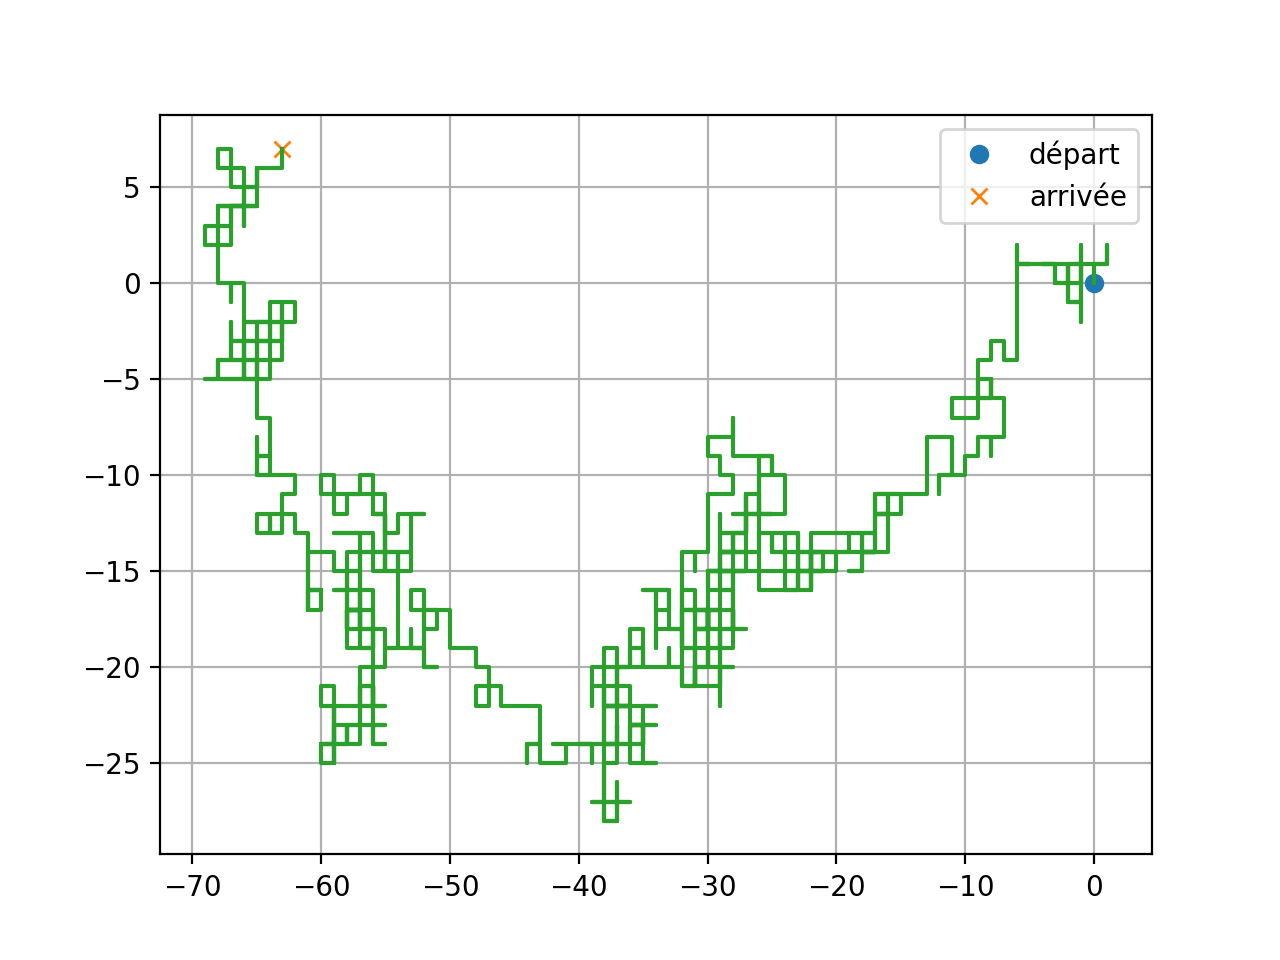

In [3]:
pos_1=np.zeros((nd,2)) # tableau contenant nd couples de deux valeurs (x,y)
for i in range(1,nd):
    step=[[a,0],[-a,0],[0,a],[0,-a]]
    choix=np.array([0,1,2,3])
    ind = np.random.choice(choix,1)[0]#Un pas en avant ou un pas en arrière?
    pos_1[i,:]=pos_1[i-1,:] + step[ind]
    
plt.figure()
plt.plot(0,0,'o', label='départ')
plt.plot(pos_1[nd-1,0],pos_1[nd-1,1],'x', label='arrivée')
plt.legend()
plt.plot(pos_1[:,0],pos_1[:,1])
plt.grid(True)
plt.show()

Pour que la modélisation est un sens il faut multiplier les particules suivies et en tirer des valeurs statistiques moyennes. On crée donc un tableau `position` identique à `pos_1` mais contenant `Num` particules au lieu d'une seule.

In [4]:
#Nombre de trajectoires
Num = 1000 #Nb de trajectoires calculées
position = np.zeros((Num,nd,2)) #Tableau contenant toutes les positions 2D au cours du temps

In [5]:
# Simulation des trajectoires
for j in range(Num):
    for i in range(1,nd) :
        step=[[a,0],[-a,0],[0,a],[0,-a]]
        choix=np.array([0,1,2,3])
        ind = np.random.choice(choix,1)[0]#Un pas en avant ou un pas en arrière?
        position[j,i,:] = position[j,i-1,:] + step[ind]

On trace les trajectoires individuelles, en veillant à conserver le rapport d'aspect des deux axes du graphique grâce à la commande `plt.axis('equal')`.</br>

*Attention le tracé peut-être long si `Num` est élevé.*

<IPython.core.display.Javascript object>


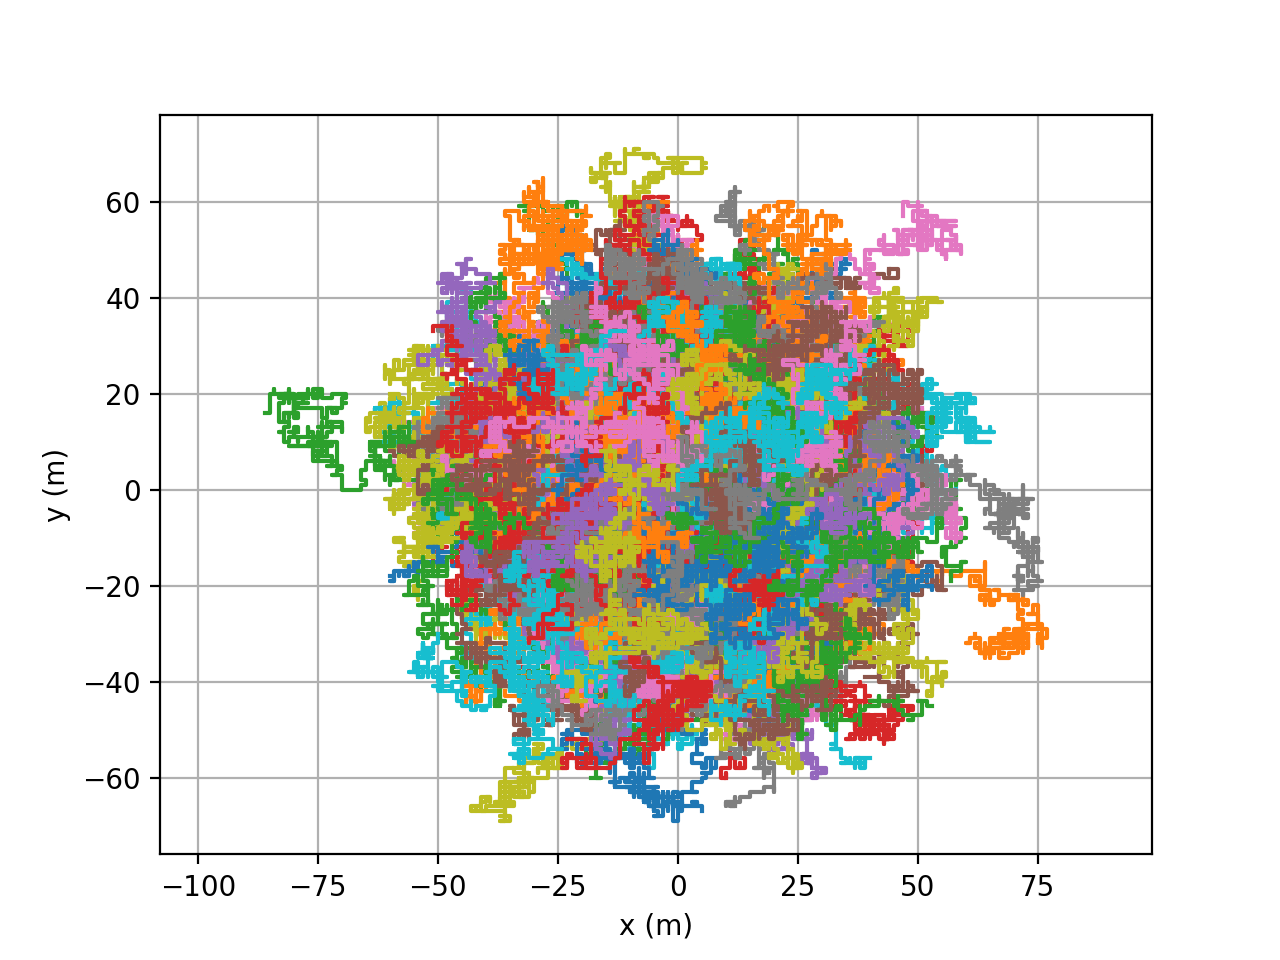

In [6]:
# Tracé de la trajectoire de chaque particule suivie
plt.figure('Evolution spatiale individuelle')
plt.axis('equal')
plt.grid(True)
j = 0
for j in range(Num):
    x=position[j,:,0]
    y=position[j,:,1]
    plt.plot(y,x)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

## Analyse des résultats obtenus
Si la valeur `Num` est suffisamment élevée, les quatre directions de l'espace sont équitablement visitées et la "surface" occupée par les particules s'approche d'un disque.

&nbsp;
On peut chercher à relier le rayon moyen de ce disque à l'instant $t$ auquel s'arrête la simulation. Si on note $\vec{d}_i=M_iM_{i+1}$ le déplacement réalisé àl'étape $i$, on peut exprimer le rayon atteint par le point $M_k$ à l'étape $k$ par le calcul de $R_k^2=\overrightarrow{OM_k}^2=\left(\sum_{i=0}^{k-1}\vec{d}_i\right)^2$. On en déduit :
$$R_k^2=\sum_{i=0}^{k-1} d_k^2 + \sum_{i\neq j}\vec{d_i}\cdot\vec{d_j}$$

&nbsp;
Le rayon moyen devient alors :
$$\left<R_k^2\right>=Na^2 + 0$$

&nbsp;
En remarquant que $N=\frac{T_\text{max}}{\Delta t}$, il vient : 
$$\left<R_k^2\right>=\dfrac{a^2}{\Delta t}t=4Dt$$

&nbsp;
C'est ce rayon moyen que l'on va calculer en mesurant, à chaque instant, la moyenne des distances $\ell^2=x^2+y^2$ parcourue par les diverses trajectoires. Cette moyenne sera stockée à chaque instant dans la liste `xyquad`, puis tracée dans le graphe ci-dessous.

&nbsp;
On pourra alors comparer cette moyenne à la droite $y=4Dt$ prédite par l'approche statistique développée ci-dessus.

<IPython.core.display.Javascript object>


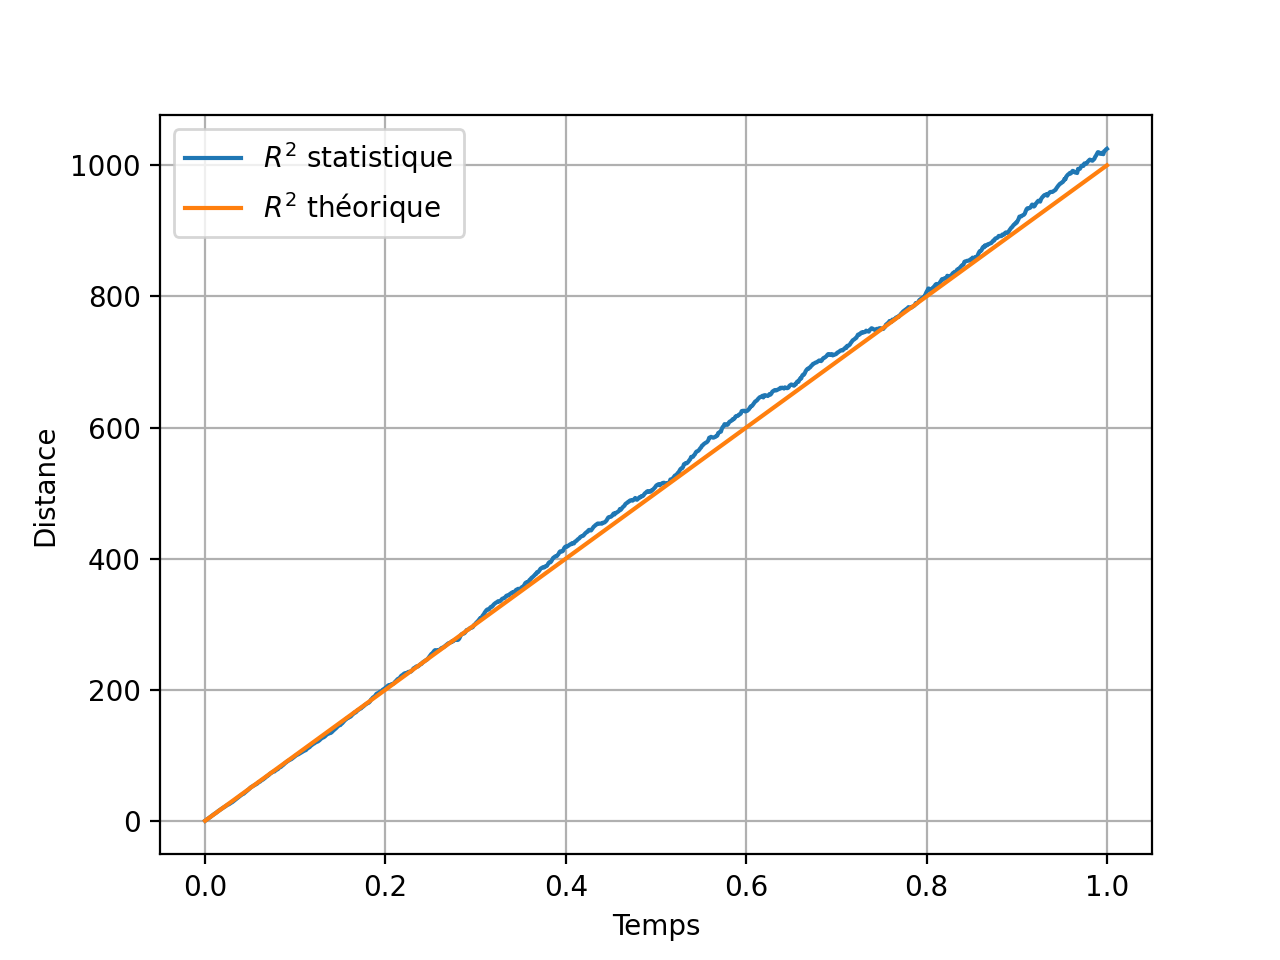

In [7]:
# Tracé de l'évolution temporelle de la moyenne instantannée et quadratique
xyquad=np.zeros(nd)

for i in range(nd): 
    xyquad[i]=np.mean(position[:,i,0]**2+position[:,i,1]**2)

plt.figure('Evolution temporelle')
plt.plot(t,xyquad, label=r"$R^2$ statistique")
plt.plot(t,4*D_th*t, label=r"$R^2$ théorique")
plt.legend()

plt.xlabel('Temps')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

On peut alors faire une évaluation statistique du coefficient de diffusion pour en donner une valeur expérimentale, accompagnée de son incertitude-type.

<IPython.core.display.Javascript object>


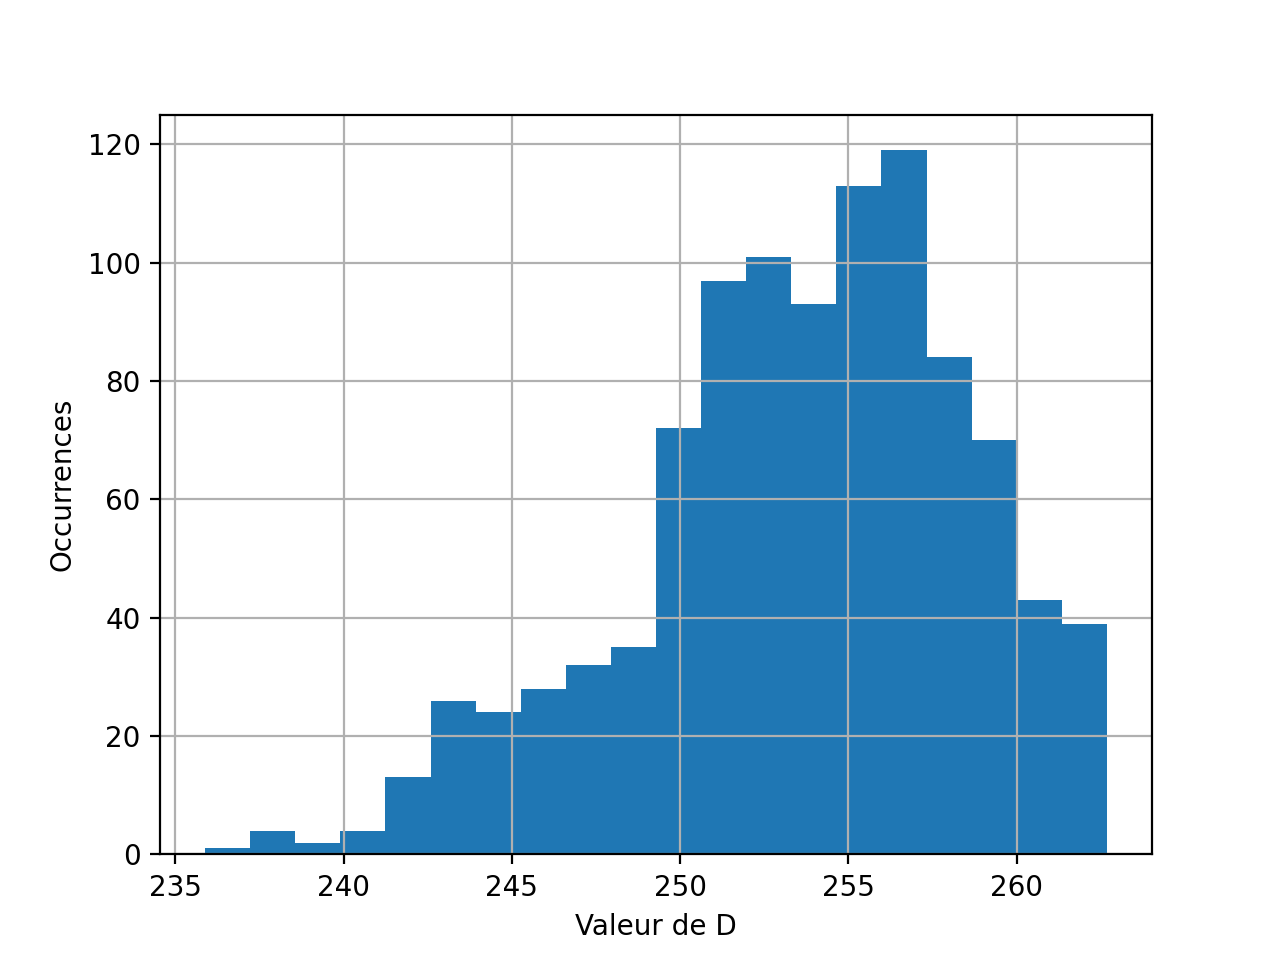

La valeur moyenne mesurée du coefficient de diffusion est  253.608 +/- 4.932 m^2/s
La valeur théorique du coefficient de diffusion est  250.000 m^2/s


In [8]:
Diff=xyquad[1:]/t[1:]

D_mean = np.mean(Diff/4)
D_u = np.std(Diff/4, ddof=1)

plt.figure()
plt.hist(Diff/4,bins='rice')
plt.grid(True)
plt.xlabel('Valeur de D')
plt.ylabel('Occurrences')
plt.show()

print("La valeur moyenne mesurée du coefficient de diffusion est ",format(D_mean,"#.3f"),"+/-",format(D_u,"#.3f"),"m^2/s")
print("La valeur théorique du coefficient de diffusion est ",format(D_th,"#.3f"),"m^2/s")


